<a href="https://colab.research.google.com/github/BaiLiping/BLP/blob/master/DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import math
import sys
wave_length=0.7
phase=180/5

def generate_target():
    index=np.random.choice(range(48))
    position=np.unravel_index(index,(8,6))
    return position
    
def location_info(target_location):
    distance=math.sqrt(pow((3*(target_location[0])),2)+pow(3*(target_location[1]),2))
    impact=(1/(distance+1))*30*math.cos(distance/wave_length)
    return impact
        
def compute_reward(x,y,p,target_location):
    distance=math.sqrt(pow((3*(x-target_location[0])),2)+pow(3*(y-target_location[1]),2))
    reward=(1/(distance+1))*30*math.cos(distance/wave_length+(p-1)*phase)
    return reward

class PhasedArrayEnv(object):
    def __init__(self):
        self.wave_length=0.7
        self.phase=180/5
        self.nA=47*6
        self.state=np.zeros(48)
        self.target_location=generate_target()
    
    def reset(self):
        self.target_location=generate_target()
        self.state=np.zeros(48)
        self.state[0]=location_info(self.target_location)
        return self.state
    
    def get_nA(self):
        return self.nA

    def step(self,action):
        x=np.unravel_index(action+5,(8,6,6))[0]
        y=np.unravel_index(action+5,(8,6,6))[1]
        p=np.unravel_index(action+5,(8,6,6))[2]+1
        state_index=np.ravel_multi_index((x,y),(8,6))
        self.state[state_index]=p
        reward=compute_reward(x,y,p,self.target_location)
        return self.state,reward
    
    def render(self):
        outfile=sys.stdout
        for i in range(48):
            position=np.unravel_index(i,(8,6))
            if self.state[i]!=0:
                output='  '
                output+=str(int(self.state[i]))
                output+='  '
            else:
                output='  _  '
    
            if position[1]==0:
                output=output.lstrip()
            if position[1]==(8,6)[1]-1:
                output=output.rstrip()
                output+='\n'
            outfile.write(output)
        outfile.write('\n')

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

done learning


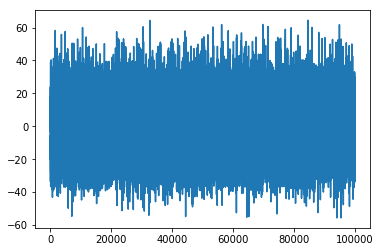

Ep:  0 | Ep_r:  -0.5405326589009385
Ep:  1 | Ep_r:  -8.47824725366007
Ep:  2 | Ep_r:  4.100704484221751
Ep:  3 | Ep_r:  -8.557574104037649


In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

tf.set_random_seed(1)
np.random.seed(1)

# Hyper Parameters
BATCH_SIZE = 32
LR = 0.1                   # learning rate
EPSILON = 0.9               # greedy policy
GAMMA = 0.9                 # reward discount
TARGET_REPLACE_ITER = 100   # target update frequency
MEMORY_CAPACITY = 2000
MEMORY_COUNTER = 0          # for store experience
LEARNING_STEP_COUNTER = 0   # for target updating
env=PhasedArrayEnv()
N_ACTIONS = env.get_nA()
N_STATES = 48
MEMORY = np.zeros((MEMORY_CAPACITY, N_STATES * 2 + 2))     # initialize memory

# tf placeholders
tf_s = tf.placeholder(tf.float32, [None, N_STATES])
tf_a = tf.placeholder(tf.int32, [None, ])
tf_r = tf.placeholder(tf.float32, [None, ])
tf_s_ = tf.placeholder(tf.float32, [None, N_STATES])

with tf.variable_scope('q_eval'):
    l1_eval = tf.layers.dense(tf_s, 64, tf.nn.relu, kernel_initializer=tf.random_normal_initializer(0, 0.1))
    l2_eval = tf.layers.dense(l1_eval,32,tf.nn.relu,kernel_initializer=tf.random_normal_initializer(0, 0.1))
    q = tf.layers.dense(l2_eval, N_ACTIONS, kernel_initializer=tf.random_normal_initializer(0, 0.1))
with tf.variable_scope('q_target'):
    l1_target = tf.layers.dense(tf_s_, 64, tf.nn.relu, trainable=False)
    l2_target=tf.layers.dense(l1_target,32,tf.nn.relu,trainable=False)
    q_next = tf.layers.dense(l2_target, N_ACTIONS, trainable=False)

q_target = tf_r + GAMMA * tf.reduce_max(q_next, axis=1)                   # shape=(None, ),
a_indices = tf.stack([tf.range(tf.shape(tf_a)[0], dtype=tf.int32), tf_a], axis=1)
q_target_a = tf.gather_nd(params=q, indices=a_indices)     # shape=(None, ), q for current state
loss = tf.reduce_mean(tf.squared_difference(q_target, q_target_a))
loss_clip=tf.clip_by_value(loss,1e-8,1000)
train_op = tf.train.AdamOptimizer(LR).minimize(loss_clip)

sess = tf.Session()
sess.run(tf.global_variables_initializer())


def choose_action(s):
    s = s[np.newaxis, :]
    if np.random.uniform() < EPSILON:
        actions_value = sess.run(q, feed_dict={tf_s: s})
        action = np.argmax(actions_value)
    else:
        action = np.random.randint(0, N_ACTIONS)
    return action


def store_transition(s, a, r, s_):
    global MEMORY_COUNTER
    transition = np.hstack((s, [a, r], s_))
    # replace the old memory with new memory
    index = MEMORY_COUNTER % MEMORY_CAPACITY
    MEMORY[index, :] = transition
    MEMORY_COUNTER += 1


def learn():
    # update target net
    global LEARNING_STEP_COUNTER
    if LEARNING_STEP_COUNTER % TARGET_REPLACE_ITER == 0:
        t_params = tf.get_collection(tf.GraphKeys.MODEL_VARIABLES, scope='q_target')
        e_params = tf.get_collection(tf.GraphKeys.MODEL_VARIABLES, scope='q_eval')
        sess.run([tf.assign(t, e) for t, e in zip(t_params, e_params)])
    LEARNING_STEP_COUNTER += 1

    # learning
    sample_index = np.random.choice(MEMORY_CAPACITY, BATCH_SIZE)
    b_memory = MEMORY[sample_index, :]
    b_s = b_memory[:, :N_STATES]
    b_a = b_memory[:, N_STATES].astype(int)
    b_r = b_memory[:, N_STATES+1]
    b_s_ = b_memory[:, -N_STATES:]
    sess.run(train_op, {tf_s: b_s, tf_a: b_a, tf_r: b_r, tf_s_: b_s_})
reward_memory=[]
print('\nCollecting experience...')
for i_episode in range(100000):
    s = env.reset()
    ep_r = 0
    action_memory=[]
    for step in range(10):
        a = choose_action(s)
        while True:
            if a in action_memory:
                a=choose_action(s)
            else:
                action_memory.append(a)
                break
        # take action
        s_, r = env.step(a)

        store_transition(s, a, r, s_)

        ep_r += GAMMA*r
        if MEMORY_COUNTER > MEMORY_CAPACITY:
            learn()

        s = s_
    #print('Ep: ', i_episode, '| Ep_r: ', ep_r)
    reward_memory.append(ep_r)

print('done learning')
plt.scatter(range(100000),reward_memory)
plt.show()
for i_episode in range(4):
    s = env.reset()
    ep_r = 0
    action_memory=[]
    for step in range(10):
        a = choose_action(s)
        while True:
            if a in action_memory:
                a=choose_action(s)
            else:
                action_memory.append(a)
                break
        # take action
        s_, r = env.step(a)

        ep_r += GAMMA*r


        s = s_
    print('Ep: ', i_episode, '| Ep_r: ', ep_r)
 

